In [1]:
###### data loader####
#import clip
import pickle
from tqdm import tqdm
import numpy as np
from PIL import Image
from math import log, sqrt, pi
import argparse
from torch import nn, optim
from torch.autograd import Variable, grad
from scipy import linalg as la
from transformers import CLIPProcessor, CLIPModel
import math
import torchvision.transforms as tvt
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipfile
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as tfms
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision.utils import make_grid
from torchvision import utils
from PIL import Image
import random
from tqdm import trange
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import confusion_matrix

torch.set_num_threads(5)   # Sets the number of threads used for intra-operations
torch.set_num_interop_threads(5)   # Sets the number of threads used for inter-operations

import open_clip


data_dir = r"../../../Dataset/data/waterbirds_v1.0"
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
batch_size = 1



def get_transform_clip():
    transform = tfms.Compose([       
        tfms.Resize((224,224)),
        tfms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    return transform


model,_, preprocess =  open_clip.create_model_and_transforms("ViT-L-14", pretrained='laion2b_s32b_b82k') #ViTB/32
model = model.to(device)
tokenizer = open_clip.get_tokenizer('ViT-L-14')




def seed_everything(seed):
    """
    Changes the seed for reproducibility. 
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    

class ConfounderDataset_test(Dataset):
    def __init__(self, path):
        with open(path, 'rb') as file:
            self.data = pickle.load(file)
        self.transform = get_transform_clip()


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item =  self.data[idx]
        y = item['y']
        a = item['a']
        filename = item['filename'].replace("../../", "")
        img_filename = os.path.join(
            '../../../Dataset/data',
            filename)       
        image = Image.open(img_filename).convert("RGB")
        bbox = item['bbox']  # bbox format: [x_min, y_min, x_max, y_max]
        x_min, y_min, x_max, y_max = bbox
        cropped_image = image.crop((x_min, y_min, x_max, y_max))

        # Apply mask to image
        image_tensor = tfms.ToTensor()(cropped_image)  

        if self.transform:
            image_tensor = self.transform(image_tensor)

        return image_tensor, y, a



path = '../../../Dataset/data/wb_segments/segments_wbs.pkl'
test_dataset = ConfounderDataset_test(path)


test_data_loader  = torch.utils.data.DataLoader(dataset = test_dataset,
                                                batch_size= batch_size,
                                                shuffle=False,
                                                num_workers=0,
                                                drop_last=False)
print('Done')

Done


In [2]:
x , y,z = test_dataset[0]

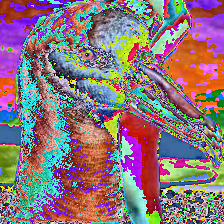

In [3]:
to_pil = tfms.ToPILImage()
image = to_pil(x)
image

In [4]:
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import minmax_scale
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import gaussian_filter
from sklearn.cluster import AgglomerativeClustering
from collections import deque, defaultdict
import time
from sklearn.manifold import TSNE



def test_epoch(vlm,   dataloader):  
    vlm = vlm.to(device)
    vlm.eval()   
    texts_label = ["a photo of a landbird.", "a photo of waterbird."] 
    text_label_tokened = tokenizer(texts_label).to(device)
    text_embeddings = vlm.encode_text(text_label_tokened)

    overall_correct = 0
    overall_total = 0
    correct = defaultdict(float)
    total = defaultdict(float)

    for step, (test_input, test_target, sensitive_real) in enumerate(tqdm(dataloader, desc="Testing")):
        with torch.no_grad(): 
            start_step1 = time.time()
            gt = test_target.detach().cpu().numpy()
            sen = sensitive_real.detach().cpu().numpy()      
            test_input = test_input.to(device)
            img_embeddings = vlm.encode_image(test_input)  #torch.Size([1, 257, 768])
            img_embeddings = img_embeddings/img_embeddings.norm(dim=1, keepdim=True)
            text_embeddings = text_embeddings/text_embeddings.norm(dim=1, keepdim=True)

            cosine_similarity = torch.mm(img_embeddings, text_embeddings.t())

            logits_per_image = cosine_similarity 
            probs = logits_per_image.softmax(dim=1)
            _, predic = torch.max(probs.data, 1)
            predic = predic.detach().cpu()

            label = test_target.detach().cpu()
            overall_correct += (predic == label).sum()
            overall_total += len(test_target.reshape(-1).detach().cpu())
            
            unique_groups = np.unique(np.stack([label, sensitive_real], axis=1), axis=0)
            for group in unique_groups:
                mask = (label == group[0]) & (sensitive_real == group[1])
                correct[tuple(group)] += (predic[mask] == label[mask]).sum()
                total[tuple(group)] += mask.sum()

    
    # Calculate and print the accuracy for each group
    for group, correct_count in correct.items():
        accuracy = correct_count / total[group]
        print(f'Accuracy for label={group[0]}, sensitive={group[1]}: {accuracy:.5f} (total: {total[group]})')

    overall_accuracy = overall_correct / overall_total
    print(f'Overall accuracy: {overall_accuracy:.5f} (total: {overall_total})')
    
            

seed_everything(10)  
model = model.to(device)
model = model.eval()
test_epoch(model, test_data_loader)

Testing: 100%|██████████████████████████████████████████████████████████████████████| 5769/5769 [03:38<00:00, 26.45it/s]

Accuracy for label=1, sensitive=1: 0.92031 (total: 640.0)
Accuracy for label=1, sensitive=0: 0.82969 (total: 640.0)
Accuracy for label=0, sensitive=0: 0.94610 (total: 2245.0)
Accuracy for label=0, sensitive=1: 0.66800 (total: 2244.0)
Overall accuracy: 0.82215 (total: 5769)
